In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
%matplotlib inline

# Data preprocessing 
## Data preparation:
* Fix NA values
* Parse date-time into pandas dataframe index
* Specified clear names for each columns

In [2]:
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

In [3]:
temp = pd.read_csv('data_hrly.csv')

In [4]:
dataset = pd.read_csv('data_hrly.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
dataset['pollution'].fillna(0, inplace=True)
dataset['month'] = np.array(temp['month'])
dataset = dataset[24:]
print("** DATA PROCESSING COMPLETED **")
dataset.to_csv('pollution.csv')

** DATA PROCESSING COMPLETED **


# Importing and visualizing the data


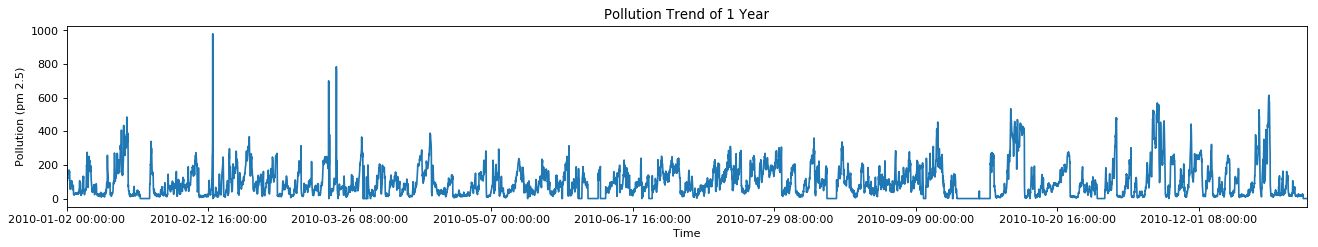

In [5]:
dataset = pd.read_csv('pollution.csv',index_col='date')
fig=plt.figure(figsize=(20, 3), dpi= 80, facecolor='w', edgecolor='k')
dataset['pollution'][:365*24].plot()
plt.title('Pollution Trend of 1 Year')
plt.xlabel('Time')
plt.ylabel('Pollution (pm 2.5)')
plt.show()

In [6]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
#Label Encoder
lbe = LabelEncoder()
#One hot encoder for the wind direction
ohe = OneHotEncoder(categorical_features=[4])
ohe_month = OneHotEncoder(categorical_features=[10])
pol_scaler = MinMaxScaler()
wea_scaler = MinMaxScaler()

In [7]:
dataset = pd.read_csv('pollution.csv',index_col='date')
dataset['wnd_dir'] = lbe.fit_transform(dataset['wnd_dir'])
dataset= pd.DataFrame(ohe.fit_transform(dataset).toarray()[:,1:])
dataset = ohe_month.fit_transform(dataset).toarray()
dataset = pd.DataFrame(dataset[:,1:])
pollution_data=np.array(dataset.iloc[:,14])
weather_data=np.array(dataset.drop(14,axis=1))
pollution_data =pol_scaler.fit_transform(pollution_data.reshape(-1,1))
#Creating the dataset for DNN
weather_data = wea_scaler.fit_transform(weather_data)
print("Shape: ",weather_data.shape)

Shape:  (43800, 20)


# Splitting the data into train and test set

In [8]:
#FOR RNN DATA
training_set_rnn = pollution_data[:40000,:]
training_set_dnn = weather_data[:40000,:]
test_set_rnn = pollution_data[40000:,:]
test_set_dnn = weather_data[40000:,:]

In [9]:
def next_batch(training_data_rnn,training_data_dnn,steps):
    """
    INPUT: Data(For RNN and DNN), Time Steps per batch
    OUTPUT: Input batch for RNN and DNN at 't' and Output data (pollution) at 't+1'
    """
    
    # Randomly initializing the start point
    ts_start = np.random.randint(low = 0, high = len(training_data_rnn)-steps)
    # the random start to random start + steps + 1. Then reshape this data to be (1,steps+1)
    y_batch_rnn = training_data_rnn[ts_start: ts_start + steps + 1]
    y_batch_dnn = training_data_dnn[ts_start: ts_start + steps + 1]
    # Values for RNN reshaped to (-1,steps,1)
    return y_batch_rnn[:-1,:].reshape(-1,steps,1) , y_batch_dnn[:-1,:].reshape(steps,-1),y_batch_rnn[1:,:].reshape(-1,steps,1)
    

In [10]:
import os
#Setting up tensorflow on GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
from nn_function import *

In [11]:
#Reseting the default global graph
tf.reset_default_graph()

# Creating the neural network

In [12]:
#Declarying the constants
NUMBER_NEU = 128
N_IP = 1
N_OP = 1
STEPS = 24*3
LR = 0.0001
#For 40k iterations
ITER = 40000
#Output neurons for the LSTM and DNN layers
N_OUT =128

In [13]:
#Placeholders for input batches
x_rnn = tf.placeholder(dtype=tf.float32,shape=(None,None,N_IP))
x_dnn = tf.placeholder(dtype=tf.float32,shape=(None,20))
#Placeholders for output batches
y= tf.placeholder(dtype=tf.float32,shape=(None,None,N_OP))
#For dropout layers
hold_proba = tf.placeholder(dtype=tf.float32)

In [14]:
#Making the LSTM cell
cell = dropout_wrapper(hold_proba,create_LSTM_cell(NUMBER_NEU))

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


In [15]:
#RNN output
output , states = create_RNN(cell,x_rnn)
#Selecting the final output form the layer
rnn_output = output[-1]
#Connecting the output to a DNN layer
lstm_fc_out = dnn_layer(rnn_output,N_OUT,name="LSTM_op")
lstm_fc_drop = tf.nn.dropout(lstm_fc_out, hold_proba,name="drop0")

In [16]:
#Making the dnn layers with the DNN data
dnn_op = dnn_layer(x_dnn,N_OUT)

In [17]:
#Connecting/Concatenating the DNN and RNN layers
connected_layer = tf.concat([dnn_op, lstm_fc_drop], axis=1,name="connected")
dropout_layer = tf.nn.dropout(connected_layer,hold_proba,name="drop1")
#Adding another DNN+dropout layer with relu activation
connected_layer2 = tf.nn.relu(dnn_layer(dropout_layer,size=1024),name="dnn1")
dropout_layer2 = tf.nn.dropout(connected_layer2,hold_proba,name="drop2")

In [18]:
#Calculating the final output node with Sigmoid activation
network_op = tf.sigmoid(dnn_layer(dropout_layer2,1),name="network_op")

In [19]:
#Creating the MAE loss function
loss = tf.reduce_mean(tf.abs(network_op-y))
#Creating the optimizer and trainer
optim = tf.train.AdamOptimizer(learning_rate=LR)
train = optim.minimize(loss)

In [20]:
#Creating the varaible initializer and saver
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [21]:
with tf.Session() as sess:
    sess.run(init)
    for i in range(ITER):
        x_rnn_batch,x_dnn_batch,y_batch = next_batch(training_set_rnn,training_set_dnn,steps=STEPS)
        sess.run(train,feed_dict = {x_rnn:x_rnn_batch,x_dnn:x_dnn_batch ,y: y_batch , hold_proba:0.8})
        if i % 100 == 0:
            x_rnn_test,x_dnn_test,y_test = next_batch(test_set_rnn,test_set_dnn,steps=24*3)
            print("At step",i,"\t\tMean Absolute Error (Train): %1.5f"%(sess.run(loss,feed_dict = {x_rnn:x_rnn_batch,x_dnn:x_dnn_batch ,y: y_batch , hold_proba:1.0})),"\t\tMean Absolute Error (Test): %1.5f"%(sess.run(loss,feed_dict = {x_rnn:x_rnn_test,x_dnn:x_dnn_test ,y: y_test , hold_proba:1.0})))
    saver.save(sess, "Pollution_model_1Hr/model")

At step 0 		Mean Absolute Error (Train): 0.59984 		Mean Absolute Error (Test): 0.46535
At step 100 		Mean Absolute Error (Train): 0.06827 		Mean Absolute Error (Test): 0.19540
At step 200 		Mean Absolute Error (Train): 0.03107 		Mean Absolute Error (Test): 0.04202
At step 300 		Mean Absolute Error (Train): 0.03447 		Mean Absolute Error (Test): 0.04303
At step 400 		Mean Absolute Error (Train): 0.05476 		Mean Absolute Error (Test): 0.09243
At step 500 		Mean Absolute Error (Train): 0.02148 		Mean Absolute Error (Test): 0.01299
At step 600 		Mean Absolute Error (Train): 0.02611 		Mean Absolute Error (Test): 0.01641
At step 700 		Mean Absolute Error (Train): 0.07062 		Mean Absolute Error (Test): 0.06665
At step 800 		Mean Absolute Error (Train): 0.02067 		Mean Absolute Error (Test): 0.02311
At step 900 		Mean Absolute Error (Train): 0.04065 		Mean Absolute Error (Test): 0.02612
At step 1000 		Mean Absolute Error (Train): 0.03331 		Mean Absolute Error (Test): 0.01870
At step 1100 		Mean Ab

At step 9200 		Mean Absolute Error (Train): 0.02433 		Mean Absolute Error (Test): 0.01575
At step 9300 		Mean Absolute Error (Train): 0.01219 		Mean Absolute Error (Test): 0.01451
At step 9400 		Mean Absolute Error (Train): 0.02145 		Mean Absolute Error (Test): 0.02742
At step 9500 		Mean Absolute Error (Train): 0.01316 		Mean Absolute Error (Test): 0.01007
At step 9600 		Mean Absolute Error (Train): 0.00894 		Mean Absolute Error (Test): 0.01820
At step 9700 		Mean Absolute Error (Train): 0.00941 		Mean Absolute Error (Test): 0.00860
At step 9800 		Mean Absolute Error (Train): 0.02175 		Mean Absolute Error (Test): 0.02472
At step 9900 		Mean Absolute Error (Train): 0.01561 		Mean Absolute Error (Test): 0.01103
At step 10000 		Mean Absolute Error (Train): 0.01998 		Mean Absolute Error (Test): 0.02851
At step 10100 		Mean Absolute Error (Train): 0.04594 		Mean Absolute Error (Test): 0.01784
At step 10200 		Mean Absolute Error (Train): 0.01487 		Mean Absolute Error (Test): 0.01433
At step

At step 18300 		Mean Absolute Error (Train): 0.00663 		Mean Absolute Error (Test): 0.01372
At step 18400 		Mean Absolute Error (Train): 0.01963 		Mean Absolute Error (Test): 0.01640
At step 18500 		Mean Absolute Error (Train): 0.02139 		Mean Absolute Error (Test): 0.01369
At step 18600 		Mean Absolute Error (Train): 0.01400 		Mean Absolute Error (Test): 0.01334
At step 18700 		Mean Absolute Error (Train): 0.01387 		Mean Absolute Error (Test): 0.01920
At step 18800 		Mean Absolute Error (Train): 0.01665 		Mean Absolute Error (Test): 0.00860
At step 18900 		Mean Absolute Error (Train): 0.02064 		Mean Absolute Error (Test): 0.00834
At step 19000 		Mean Absolute Error (Train): 0.01496 		Mean Absolute Error (Test): 0.01468
At step 19100 		Mean Absolute Error (Train): 0.01930 		Mean Absolute Error (Test): 0.02650
At step 19200 		Mean Absolute Error (Train): 0.01479 		Mean Absolute Error (Test): 0.01713
At step 19300 		Mean Absolute Error (Train): 0.02360 		Mean Absolute Error (Test): 0.01375

At step 27400 		Mean Absolute Error (Train): 0.00699 		Mean Absolute Error (Test): 0.01448
At step 27500 		Mean Absolute Error (Train): 0.01164 		Mean Absolute Error (Test): 0.03144
At step 27600 		Mean Absolute Error (Train): 0.01412 		Mean Absolute Error (Test): 0.02626
At step 27700 		Mean Absolute Error (Train): 0.01860 		Mean Absolute Error (Test): 0.01392
At step 27800 		Mean Absolute Error (Train): 0.01151 		Mean Absolute Error (Test): 0.02617
At step 27900 		Mean Absolute Error (Train): 0.02139 		Mean Absolute Error (Test): 0.01335
At step 28000 		Mean Absolute Error (Train): 0.01019 		Mean Absolute Error (Test): 0.01396
At step 28100 		Mean Absolute Error (Train): 0.01431 		Mean Absolute Error (Test): 0.00505
At step 28200 		Mean Absolute Error (Train): 0.00829 		Mean Absolute Error (Test): 0.01320
At step 28300 		Mean Absolute Error (Train): 0.01373 		Mean Absolute Error (Test): 0.00954
At step 28400 		Mean Absolute Error (Train): 0.01590 		Mean Absolute Error (Test): 0.01346

At step 36500 		Mean Absolute Error (Train): 0.00859 		Mean Absolute Error (Test): 0.01341
At step 36600 		Mean Absolute Error (Train): 0.02492 		Mean Absolute Error (Test): 0.01215
At step 36700 		Mean Absolute Error (Train): 0.00988 		Mean Absolute Error (Test): 0.01467
At step 36800 		Mean Absolute Error (Train): 0.00634 		Mean Absolute Error (Test): 0.01292
At step 36900 		Mean Absolute Error (Train): 0.00887 		Mean Absolute Error (Test): 0.00746
At step 37000 		Mean Absolute Error (Train): 0.01108 		Mean Absolute Error (Test): 0.01057
At step 37100 		Mean Absolute Error (Train): 0.02208 		Mean Absolute Error (Test): 0.01589
At step 37200 		Mean Absolute Error (Train): 0.00786 		Mean Absolute Error (Test): 0.00819
At step 37300 		Mean Absolute Error (Train): 0.01506 		Mean Absolute Error (Test): 0.01278
At step 37400 		Mean Absolute Error (Train): 0.01169 		Mean Absolute Error (Test): 0.01160
At step 37500 		Mean Absolute Error (Train): 0.01401 		Mean Absolute Error (Test): 0.00627

# Visualizing and testing the model 

In [22]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [ ]:
with tf.Session() as sess:
    #Restoring the model
    saver.restore(sess, "Pollution_model_1Hr/model")
    #Preparing batches
    x_rnn_batch,x_dnn_batch,y_batch = next_batch(test_set_rnn,test_set_dnn,steps=1000)
    #Predicting the output
    output = sess.run(network_op, feed_dict={x_rnn:x_rnn_batch,x_dnn:x_dnn_batch, hold_proba:1.0})

INFO:tensorflow:Restoring parameters from Pollution_model_1Hr/model


In [ ]:
#Inverse scaling the predicted and actual values
y_inversed = pol_scaler.inverse_transform(y_batch.reshape(1,1000)[:,:-1]).reshape(-1,1)
pred_inversed = pol_scaler.inverse_transform(output.reshape(1,1000)[:,1:]).reshape(-1,1)
dataframe = np.append(y_inversed,pred_inversed,1)

In [ ]:
##Creating the dataframe
df = pd.DataFrame(dataframe,columns=['Actual','Prediction'])
#Plotting the graph
df[:50].plot()
plt.title("Actual Data vs Prediction Data (Test Dataset)")
plt.ylabel("Pollution")
plt.xlabel('Timestep')
plt.show()
#Calculating MAE and RMSE error
y_true = df['Actual'].values
y_pred = df['Prediction'].values
score_mae = mean_absolute_error(y_true,y_pred)
score_mse = mean_squared_error(y_true,y_pred)
print("Mean Absolute Error (Test)\t=\t",score_mae)
print("Root Mean Squared Error (Test)\t=\t",score_mse**0.5)

In [29]:
#Converting dataset to spreadsheet
df.to_csv('prediction.csv')

# Predicting Future data

In [21]:
with tf.Session() as sess:
    
    # Restoring the model
    saver.restore(sess, "Pollution_model_1Hr/model")

    #Creating the Seed of 1 Week's data
    train_seed_rnn = list(training_set_rnn[-24:])
    train_seed_dnn = list(training_set_dnn[-24:])
    test_ind = 0
    #Predicting the next week's data
    for iteration in range(24*5):
        rnn_batch = np.array(train_seed_rnn[-12:]).reshape(1, 12, 1)
        dnn_batch = np.array(train_seed_dnn[-12:])
        y_pred = sess.run(network_op, feed_dict={x_rnn:rnn_batch,x_dnn:dnn_batch, hold_proba:1.0})
        #print("\nPrediction: ",y_pred[0, -1])
        train_seed_rnn.append(y_pred[0, -1])
        #print("Feed_data: ",test_set_dnn[test_ind])
        train_seed_dnn.append(test_set_dnn[test_ind])
        test_ind+=1
        

INFO:tensorflow:Restoring parameters from Pollution_model_1Hr/model


InternalError: Blas GEMM launch failed : a.shape=(12, 20), b.shape=(20, 128), m=12, n=128, k=20
	 [[node MatMul_1 (defined at C:\Users\Admin\Desktop\ntt_pollution\nn_function.py:101)  = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_Placeholder_1_0_1/_69, Variable_2/read)]]
	 [[{{node network_op/_77}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_223_network_op", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'MatMul_1', defined at:
  File "C:\Users\Admin\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Admin\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Admin\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\Admin\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\Admin\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\Admin\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Admin\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\Admin\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Admin\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Admin\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Admin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Admin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Admin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-746d17418faa>", line 2, in <module>
    dnn_op = dnn_layer(x_dnn,N_OUT)
  File "C:\Users\Admin\Desktop\ntt_pollution\nn_function.py", line 101, in dnn_layer
    return tf.add(tf.matmul(input_layer,W),b,name=name)
  File "C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py", line 2057, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 4560, in mat_mul
    name=name)
  File "C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InternalError (see above for traceback): Blas GEMM launch failed : a.shape=(12, 20), b.shape=(20, 128), m=12, n=128, k=20
	 [[node MatMul_1 (defined at C:\Users\Admin\Desktop\ntt_pollution\nn_function.py:101)  = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_Placeholder_1_0_1/_69, Variable_2/read)]]
	 [[{{node network_op/_77}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_223_network_op", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


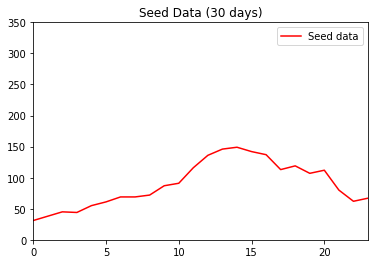

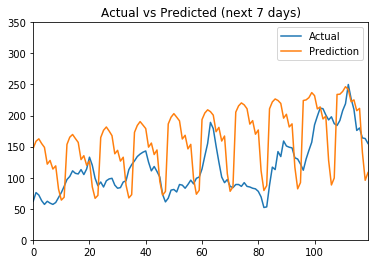

54.890554587


In [51]:
#Inverse scaling the value
seed_data = pol_scaler.inverse_transform(training_set_rnn[-24:])
prediction_data = pol_scaler.inverse_transform(np.array(train_seed_rnn[-24*5:]).reshape(1, -1))
actual_data =  pol_scaler.inverse_transform(test_set_rnn[:24*5])
pd.DataFrame(list(seed_data),columns=['Seed data']).plot(c='Red')
plt.ylim((0,350))
plt.title("Seed Data (30 days)")
plt.show()
df = pd.DataFrame({'Prediction' :prediction_data.reshape(1,-1)[0], 'Actual':actual_data.reshape(1,-1)[0]})
df.plot()
plt.ylim((0,350))
plt.title("Actual vs Predicted (next 7 days)")
plt.show()
y_true = df['Actual'].values
y_pred = df['Prediction'].values
score_mae = mean_absolute_error(y_true,y_pred)
print(score_mae)

In [52]:
df['Actual'].max()

250.00000000000003

In [53]:
df['Prediction'].max()

246.42451